In [ ]:
import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import statistics
import matplotlib.pyplot as plt
import networkx as nx
import collections
import operator
import powerlaw

# 2 Differentially expressed genes

In [2]:
C = pd.read_csv(r"C:\Users\Mohanraj\Documents\TCGA-LUSC\TCGA-LUSC_rna_expr_data_C.txt", sep = " ")
N = pd.read_csv(r"C:\Users\Mohanraj\Documents\TCGA-LUSC\TCGA-LUSC_rna_expr_data_N.txt", sep = " ")

Leave only patients with both cancer and normal data, using the patient ID in the barcode (all the patients in the N database have data in the C database too)

In [3]:
for col in C:
    if not (any([(col[8:12]==c[8:12]) for c in N.columns])):
        del C[col]
C

,TCGA-77-7142-01A-11R-2045-07,TCGA-56-7823-01B-11R-2247-07,TCGA-22-5482-01A-01R-1635-07,TCGA-56-7582-01A-11R-2045-07,TCGA-56-7730-01A-11R-2125-07,TCGA-22-5471-01A-01R-1635-07,TCGA-43-6771-01A-11R-1820-07,TCGA-22-5491-01A-01R-1635-07,TCGA-85-7710-01A-11R-2125-07,TCGA-58-8386-01A-11R-2296-07,...,TCGA-92-7340-01A-21R-2045-07,TCGA-56-7731-01A-11R-2125-07,TCGA-39-5040-01A-21R-2125-07,TCGA-56-8309-01A-11R-2296-07,TCGA-22-5472-01A-01R-1635-07,TCGA-43-6773-01A-41R-1949-07,TCGA-43-7658-01A-11R-2125-07,TCGA-22-5489-01A-01R-1635-07,TCGA-56-8083-01A-11R-2247-07,TCGA-56-8082-01A-11R-2247-07
ENSG00000000003,18.020536,12.526580,7.520130,8.570585,34.546353,18.684145,4.483961,26.265688,6.525841,5.803590,...,10.962717,13.998369,3.734452,7.995145,23.158028,4.894193,16.225508,5.218992,14.892070,32.297229
ENSG00000000005,0.051976,0.017749,0.000000,0.000000,0.014922,0.039129,0.006072,0.007913,0.000000,0.000000,...,0.000000,0.020351,0.000000,0.023971,0.000000,0.015250,0.060181,0.016743,0.000000,0.025355
ENSG00000000419,26.567243,28.267701,31.099829,31.327989,35.131989,33.612966,16.904057,47.939591,46.018540,41.393558,...,37.196983,25.164337,49.400301,27.449844,30.444776,14.300066,63.921993,29.871424,31.706126,50.747991
ENSG00000000457,2.122730,1.864069,1.899460,2.419168,2.047178,2.173772,1.119243,2.339504,4.882686,1.643590,...,1.702293,1.225780,2.338103,2.242792,2.984920,1.394726,7.362284,3.062657,3.927721,2.499827
ENSG00000000460,2.412130,3.582111,1.689431,2.884558,3.351919,2.789891,1.169817,2.527843,3.104733,1.082517,...,1.785573,0.930736,2.586417,2.034096,1.458628,1.098614,7.919506,4.786459,4.751678,2.291811
ENSG00000000938,4.205743,1.595752,1.350192,3.100640,1.428090,3.998591,1.398628,1.243152,3.027341,10.406187,...,4.166060,8.431808,1.624999,19.435288,7.516092,6.947262,3.625786,4.865272,1.773935,2.467627
ENSG00000000971,4.896562,5.315143,4.443208,6.708845,1.834698,3.335541,9.253004,1.865966,34.526262,5.064992,...,17.362631,23.454584,1.982730,44.461143,24.983019,13.652155,1.808178,11.246094,8.593680,3.756390
ENSG00000001036,27.696014,23.654312,28.480229,16.366657,13.126499,23.266258,16.521400,26.514525,14.271703,12.796524,...,27.860683,29.198933,27.472402,19.282607,22.115192,22.486382,19.793734,16.451120,13.620139,26.279002
ENSG00000001084,10.028305,68.756039,74.313098,118.276670,69.327318,23.454050,0.329228,33.826146,4.154851,8.992422,...,10.111642,10.147422,4.302640,12.481228,13.410620,94.695444,4.015298,5.999440,4.474007,20.888335
ENSG00000001167,11.782569,17.590674,10.254374,19.844074,12.179612,7.302404,5.702644,4.178549,15.803207,7.004460,...,6.637829,6.796353,22.628566,9.438083,9.074606,9.515498,23.306856,19.112425,12.071453,9.683216


Delete the genes (rows) with at least one zero value

In [4]:
MC = C.to_records()
MN = N.to_records()
Cclean = C.to_records()
Nclean = N.to_records()

In [5]:
to_delete = set()  # Set of index to delete
for i in range(len(MC)):
    if (0 in MC[i]):
        to_delete.add(i)

for i in range(len(MN)):
    if (0 in MN[i]):
        to_delete.add(i)
        
Cclean = np.delete(Cclean, list(to_delete), axis=0)
Nclean = np.delete(Nclean, list(to_delete), axis=0)

### Keep only the genes with a One-way ANOVA familywise q-value < 0.05 (calculated with Bonferroni threshold), and a fold change greater than 1.5 or below -1.5.

In [6]:
# Bonferroni threshold
def bonferroni_thresh(alpha_fwe, n):
    return alpha_fwe / n
bon_thresh = bonferroni_thresh(0.05, len(Cclean[0])) # P-value to use calculated with Bonferroni threshold that gives a familywise error < 0.05

In [7]:
genes = []  # List of the names of the differential expressed genes
idx = [] # Index to drop


# Lists needed for volcano plot
green = []
red = []
grey = []
yg = []
yr = []
ygrey = []


for i in range(len(Cclean)):
    # p-value
    p = stats.f_oneway([math.log(y,2) for y in list(Cclean[i])[1:]], [math.log(x,2) for x in list(Nclean[i])[1:]])[1]
    # fold change
    fc = math.log(statistics.mean(list(Cclean[i])[1:])/statistics.mean(list(Nclean[i])[1:]),2)
    if (p < bon_thresh) and (fc > 2):
        genes.append(Cclean[i][0])
        red.append(fc)
        yr.append(-math.log(p,10))
    elif (p < bon_thresh) and (fc < -2):
        genes.append(Cclean[i][0])
        green.append(fc)
        yg.append(-math.log(p,10))
    else:
        grey.append(fc)
        ygrey.append(-math.log(p,10))
        idx.append(i)

# Drop non differential expressed genes
Cclean = np.delete(Cclean, idx, axis=0)
Ncelan = np.delete(Nclean, idx, axis=0)

# Drop header with genes names
Cex = np.array([0 for i in range(len(Cclean[1])-1)])
Nex = np.array([0 for i in range(len(Cclean[1])-1)])
for i in range(len(Cclean)):
    Cex = np.vstack((Cex, list(Cclean[i])[1:]))
    Nex = np.vstack((Nex, list(Nclean[i])[1:]))
Cex = np.delete(Cex,0,0)
Nex = np.delete(Nex,0,0)
print("{} of the alayized genes are differentially expressed, they are {}% of all analyzed genes".format(len(genes),round( len(genes)/len(MC)*100 ,2)))

1695 of the alayized genes are differentially expressed, they are 2.99% of all analyzed genes


### Volcano plot: in green the downed regulated genes, in red the up regulated genes

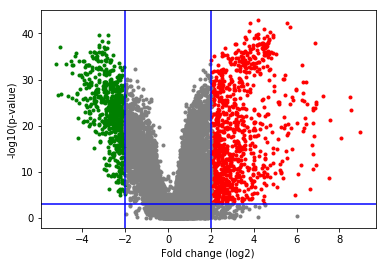

In [8]:
plt.plot(red, yr, '.', color='red')
plt.plot(green,yg,".", color="green")
plt.plot(grey,ygrey,".",color="grey")
plt.xlabel("Fold change (log2)")
plt.ylabel("-log10(p-value)")
plt.axvline(2, color='b')
plt.axvline(-2, color='b')
plt.axhline(-math.log(bon_thresh,10), color='b')
# Save plot
#plt.savefig("VolcanoPlot")

# 3 Co-expression network

In [9]:
# Apply log2 before the threshold
for i in range(len(Cclean)):
    Cex[i] = [math.log(j,2) for j in (Cex[i])]
    Nex[i] = [math.log(j,2) for j in (Nex[i])]

corr_C = np.corrcoef(Cex)
corr_N = np.corrcoef(Nex)

### Set significant threshold

In [10]:
t = 0.7
for i in range(len(corr_C)):
    for j in range(len(corr_C[i])):
        if i==j:          # Set correlation with itself to 0
            corr_C[i][j] = 0
            corr_N[i][j] = 0
        else:
            if corr_C[i][j] > t:
                corr_C[i][j] = 1
            elif corr_C[i][j] < -t:
                corr_C[i][j] = -1
            else:
                corr_C[i][j] = 0
                
            if corr_N[i][j] > t:
                corr_N[i][j] = 1
            elif corr_N[i][j] < -t:
                corr_N[i][j] = -1
            else:
                corr_N[i][j] = 0

### Degree distribution of C

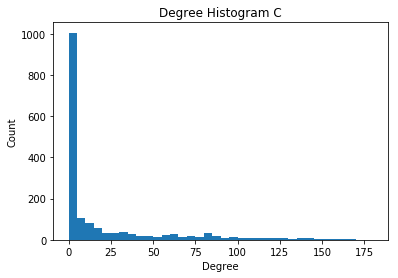

In [11]:
C = nx.from_numpy_array(corr_C)

degree_sequence = [d for n, d in C.degree()]
bins = range(0,max(degree_sequence),5)
plt.hist(degree_sequence, bins = bins)
plt.title("Degree Histogram C")
plt.ylabel("Count")
plt.xlabel("Degree")
# save plot
#plt.savefig("Degree Distribution C")

plt.show()

### Find the hubs (5% of the nodes with the highest degree) in C

In [12]:
degreeC = dict(C.degree())  # Make degree a dictionary
indexesC = sorted(degreeC, key=degreeC.get, reverse=True) # Sort index by value to find the hubs
indexesC = indexesC[:round(len(indexesC)*0.05)]
# Find the name of top hubs genes
hubsC = operator.itemgetter(*indexesC)(genes)
for i in range(len(hubsC)):
    print(hubsC[i],"with degree:", sorted(degreeC.values(), reverse = True)[i])

ENSG00000175899 with degree: 184
ENSG00000118526 with degree: 169
ENSG00000131747 with degree: 165
ENSG00000186185 with degree: 161
ENSG00000143228 with degree: 160
ENSG00000137804 with degree: 158
ENSG00000139567 with degree: 158
ENSG00000143476 with degree: 157
ENSG00000261371 with degree: 155
ENSG00000117650 with degree: 153
ENSG00000164045 with degree: 153
ENSG00000077152 with degree: 151
ENSG00000157456 with degree: 151
ENSG00000065328 with degree: 150
ENSG00000146670 with degree: 150
ENSG00000169679 with degree: 149
ENSG00000152253 with degree: 147
ENSG00000156970 with degree: 147
ENSG00000094804 with degree: 145
ENSG00000129810 with degree: 145
ENSG00000035499 with degree: 144
ENSG00000149554 with degree: 144
ENSG00000130052 with degree: 142
ENSG00000161800 with degree: 142
ENSG00000109805 with degree: 141
ENSG00000174371 with degree: 141
ENSG00000090889 with degree: 140
ENSG00000076382 with degree: 139
ENSG00000085999 with degree: 138
ENSG00000138160 with degree: 138
ENSG000001

### Do the same with N

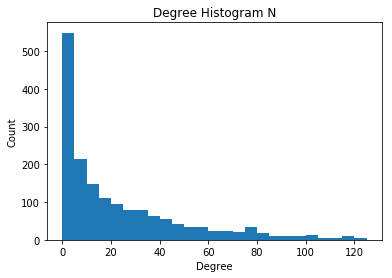

In [13]:
N = nx.from_numpy_array(corr_N)

degree_sequence = [d for n, d in N.degree()]
bins = range(0,max(degree_sequence),5)
plt.hist(degree_sequence, bins = bins)
plt.title("Degree Histogram N")
plt.ylabel("Count")
plt.xlabel("Degree")
# save plot
#plt.savefig("Degree Distribution N")

plt.show()

In [14]:
degreeN = dict(N.degree())  # Make degree a dictionary
indexesN = sorted(degreeN, key=degreeN.get, reverse=True) # Sort index by value to find the hubs
indexesN = indexesN[:round(len(indexesN)*0.05)]
# Print the list of
hubsN = operator.itemgetter(*indexesN)(genes)
for i in range(len(hubsN)):
    print(hubsN[i], "with degree:",sorted(degreeN.values(), reverse = True)[i])

ENSG00000233901 with degree: 130
ENSG00000181544 with degree: 128
ENSG00000170909 with degree: 125
ENSG00000134201 with degree: 123
ENSG00000140263 with degree: 123
ENSG00000214160 with degree: 120
ENSG00000114346 with degree: 119
ENSG00000132000 with degree: 119
ENSG00000204936 with degree: 118
ENSG00000163689 with degree: 117
ENSG00000134247 with degree: 116
ENSG00000137203 with degree: 116
ENSG00000116141 with degree: 115
ENSG00000171462 with degree: 115
ENSG00000175305 with degree: 115
ENSG00000115598 with degree: 114
ENSG00000133110 with degree: 114
ENSG00000144476 with degree: 114
ENSG00000198901 with degree: 114
ENSG00000135119 with degree: 112
ENSG00000113555 with degree: 111
ENSG00000104321 with degree: 109
ENSG00000177732 with degree: 107
ENSG00000065054 with degree: 106
ENSG00000091262 with degree: 106
ENSG00000141579 with degree: 105
ENSG00000178184 with degree: 105
ENSG00000006625 with degree: 104
ENSG00000126785 with degree: 104
ENSG00000153976 with degree: 104
ENSG000002

### Find the hubs in C that are not present in N

In [15]:
hubs = [item for item in hubsN if item not in hubsC]
print(hubs)

['ENSG00000233901', 'ENSG00000181544', 'ENSG00000170909', 'ENSG00000134201', 'ENSG00000140263', 'ENSG00000214160', 'ENSG00000114346', 'ENSG00000132000', 'ENSG00000204936', 'ENSG00000163689', 'ENSG00000134247', 'ENSG00000137203', 'ENSG00000116141', 'ENSG00000171462', 'ENSG00000175305', 'ENSG00000115598', 'ENSG00000133110', 'ENSG00000144476', 'ENSG00000135119', 'ENSG00000113555', 'ENSG00000104321', 'ENSG00000177732', 'ENSG00000065054', 'ENSG00000091262', 'ENSG00000141579', 'ENSG00000178184', 'ENSG00000006625', 'ENSG00000126785', 'ENSG00000153976', 'ENSG00000211448', 'ENSG00000140022', 'ENSG00000158560', 'ENSG00000109062', 'ENSG00000197653', 'ENSG00000243232', 'ENSG00000144891', 'ENSG00000152766', 'ENSG00000128849', 'ENSG00000169851', 'ENSG00000174059', 'ENSG00000114115', 'ENSG00000189350', 'ENSG00000164850', 'ENSG00000161940', 'ENSG00000123342', 'ENSG00000159055', 'ENSG00000197930', 'ENSG00000038945', 'ENSG00000105427', 'ENSG00000140451', 'ENSG00000158445', 'ENSG00000137868', 'ENSG000001

### Power law fit to see if C and N are scale free

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\Mohanraj\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


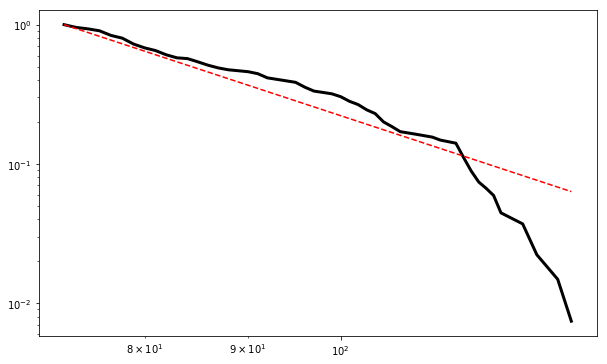

In [16]:
# fit of N
degree_sequence = sorted([d for n, d in N.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence) 
plt.figure(figsize=(10, 6))
fig = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--') #powerlaw
#save plot
#plt.savefig("Fit N")




#fitN = plfit.plfit(degree_sequence)
#plfit.plfit.test_pl(fitN)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


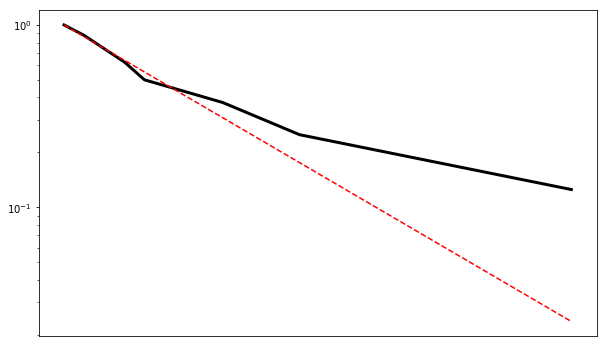

In [17]:
# fit of C
degree_sequence = sorted([d for n, d in C.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence) 
plt.figure(figsize=(10, 6))
fig = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--') #powerlaw
#save plot
#plt.savefig("Fit C")



#fitC = plfit.plfit(degree_sequence)
#plfit.plfit.test_pl(fitC)

### Differential co-expressed network

In [18]:
corr_C = np.corrcoef(Cex)
corr_N = np.corrcoef(Nex)

In [19]:
def zTransform(r):
    z = 1/2*np.log((1 + r) / (1 - r))
    return z

In [20]:
DCE = corr_C.copy()

In [21]:
for i in range(len(corr_C)):
    for j in range(len(corr_C[i])):
        p1 = corr_C[i][j]
        p2 = corr_N[i][j]
        z1 = zTransform(p1)
        z2 = zTransform(p2)
        Z = (z1-z2)/(np.sqrt((1/(len(corr_C)-3))+(1/(len(corr_N)-3))))
        if i==j:          
            DCE[i][j] = 0
        else:
            if Z < 3 and Z > -3:
                DCE[i][j] = 0
            elif Z < -3:
                DCE[i][j]= -1
            else:
                DCE[i][j] = 1

C:\Users\Mohanraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Mohanraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [22]:
DCE

array([[ 0., -1., -1., ...,  1.,  1.,  1.],
       [-1.,  0., -1., ..., -1., -1., -1.],
       [-1., -1.,  0., ..., -1.,  0.,  0.],
       ...,
       [ 1., -1., -1., ...,  0.,  0.,  1.],
       [ 1., -1.,  0., ...,  0.,  0.,  0.],
       [ 1., -1.,  0., ...,  1.,  0.,  0.]])

In [23]:
D = nx.from_numpy_array(DCE) #creating network

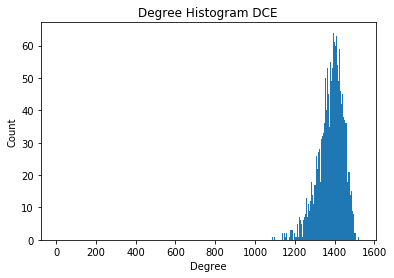

In [24]:
degree_sequence = [d for n, d in D.degree()]
bins = range(0,max(degree_sequence),5)
plt.hist(degree_sequence, bins = bins)
plt.title("Degree Histogram DCE")
plt.ylabel("Count")
plt.xlabel("Degree")
# save plot
#plt.savefig("Degree Distribution N")

plt.show()

In [25]:
degreeD = dict(D.degree())  # Make degree a dictionary
indexesD = sorted(degreeD, key=degreeD.get, reverse=True) # Sort index by value to find the hubs
indexesD = indexesD[:round(len(indexesD)*0.05)]
# Print the list of
hubsD = operator.itemgetter(*indexesD)(genes)
for i in range(len(hubsD)):
    print(hubsD[i], "with degree:",sorted(degreeD.values(), reverse = True)[i])

ENSG00000113555 with degree: 1533
ENSG00000198901 with degree: 1523
ENSG00000007129 with degree: 1506
ENSG00000175899 with degree: 1506
ENSG00000161940 with degree: 1503
ENSG00000131018 with degree: 1501
ENSG00000170989 with degree: 1499
ENSG00000183019 with degree: 1499
ENSG00000171115 with degree: 1497
ENSG00000166927 with degree: 1496
ENSG00000169418 with degree: 1496
ENSG00000170909 with degree: 1496
ENSG00000074660 with degree: 1495
ENSG00000261371 with degree: 1495
ENSG00000139567 with degree: 1494
ENSG00000035499 with degree: 1492
ENSG00000051180 with degree: 1492
ENSG00000068831 with degree: 1492
ENSG00000130307 with degree: 1492
ENSG00000149564 with degree: 1492
ENSG00000167261 with degree: 1492
ENSG00000066056 with degree: 1490
ENSG00000101057 with degree: 1490
ENSG00000069122 with degree: 1489
ENSG00000038945 with degree: 1488
ENSG00000114346 with degree: 1488
ENSG00000123342 with degree: 1488
ENSG00000143110 with degree: 1488
ENSG00000146670 with degree: 1488
ENSG0000016474

Calculating best minimal value for power law fit


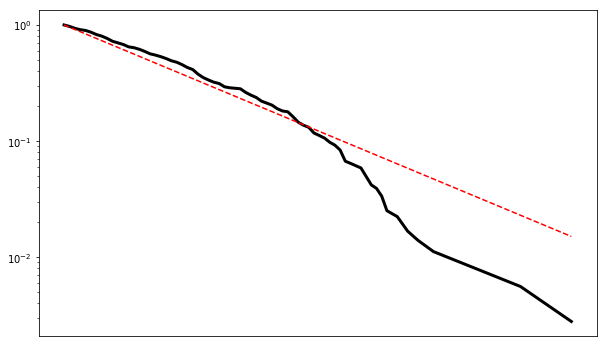

In [26]:
degree_sequence = sorted([d for n, d in D.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence) 
plt.figure(figsize=(10, 6))
fig = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--') 

#### comparing the hubs that found in task 3 with the hubs found in Differential co-expressed network

In [27]:
d_hubs = [i for i in hubs if i not in hubsD]

In [28]:
d_hubs

['ENSG00000233901',
 'ENSG00000181544',
 'ENSG00000134201',
 'ENSG00000140263',
 'ENSG00000214160',
 'ENSG00000204936',
 'ENSG00000163689',
 'ENSG00000134247',
 'ENSG00000137203',
 'ENSG00000116141',
 'ENSG00000171462',
 'ENSG00000175305',
 'ENSG00000115598',
 'ENSG00000133110',
 'ENSG00000144476',
 'ENSG00000135119',
 'ENSG00000104321',
 'ENSG00000177732',
 'ENSG00000065054',
 'ENSG00000091262',
 'ENSG00000141579',
 'ENSG00000178184',
 'ENSG00000006625',
 'ENSG00000153976',
 'ENSG00000211448',
 'ENSG00000140022',
 'ENSG00000158560',
 'ENSG00000109062',
 'ENSG00000197653',
 'ENSG00000243232',
 'ENSG00000144891',
 'ENSG00000152766',
 'ENSG00000128849',
 'ENSG00000169851',
 'ENSG00000174059',
 'ENSG00000114115',
 'ENSG00000189350',
 'ENSG00000164850',
 'ENSG00000105427',
 'ENSG00000140451',
 'ENSG00000158445',
 'ENSG00000137868',
 'ENSG00000188763',
 'ENSG00000272732',
 'ENSG00000166123',
 'ENSG00000166527',
 'ENSG00000172236',
 'ENSG00000186603',
 'ENSG00000124920',
 'ENSG00000171798',


In [32]:
#Hubs that are found in task 3 also found in task 4

In [31]:
d_in_hubs = [i for i in hubs if i in hubsD]
d_in_hubs

['ENSG00000170909',
 'ENSG00000114346',
 'ENSG00000132000',
 'ENSG00000113555',
 'ENSG00000126785',
 'ENSG00000161940',
 'ENSG00000123342',
 'ENSG00000159055',
 'ENSG00000197930',
 'ENSG00000038945',
 'ENSG00000143110']

In [32]:
len(d_hubs),len(d_in_hubs)

(71, 11)

In [91]:
hub = D.subgraph(hlist)

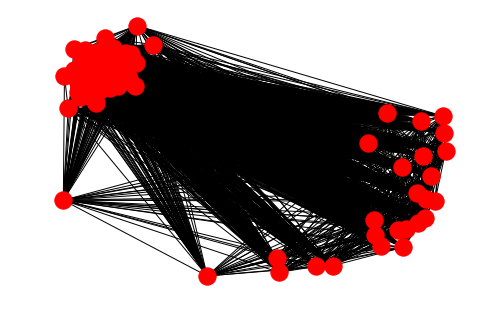

In [92]:
nx.draw(hub)
plt.savefig("hub1.png") 

In [93]:
hlist=[]
for i in range(len(d_hubs)):
    d=sorted(degreeD.values(), reverse = True)[i]
    for n,v in degreeD.items():
        if v==d:
            hlist.append(n)

In [94]:
hlist

[356,
 1431,
 17,
 1213,
 17,
 1213,
 922,
 537,
 1122,
 1286,
 1122,
 1286,
 1127,
 1039,
 1095,
 1121,
 1039,
 1095,
 1121,
 1039,
 1095,
 1121,
 122,
 1622,
 122,
 1622,
 669,
 52,
 67,
 97,
 529,
 790,
 1045,
 52,
 67,
 97,
 529,
 790,
 1045,
 52,
 67,
 97,
 529,
 790,
 1045,
 52,
 67,
 97,
 529,
 790,
 1045,
 52,
 67,
 97,
 529,
 790,
 1045,
 52,
 67,
 97,
 529,
 790,
 1045,
 89,
 215,
 89,
 215,
 100,
 55,
 362,
 451,
 706,
 757,
 993,
 55,
 362,
 451,
 706,
 757,
 993,
 55,
 362,
 451,
 706,
 757,
 993,
 55,
 362,
 451,
 706,
 757,
 993,
 55,
 362,
 451,
 706,
 757,
 993,
 55,
 362,
 451,
 706,
 757,
 993,
 526,
 568,
 680,
 526,
 568,
 680,
 526,
 568,
 680,
 187,
 437,
 187,
 437,
 54,
 487,
 1086,
 54,
 487,
 1086,
 54,
 487,
 1086,
 703,
 1339,
 703,
 1339,
 477,
 544,
 477,
 544,
 36,
 329,
 409,
 1104,
 1253,
 36,
 329,
 409,
 1104,
 1253,
 36,
 329,
 409,
 1104,
 1253,
 36,
 329,
 409,
 1104,
 1253,
 36,
 329,
 409,
 1104,
 1253,
 1124,
 1442,
 1124,
 1442,
 152,
 374,
 8

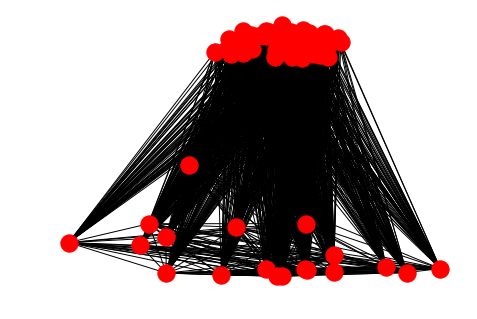

In [95]:
hub = D.subgraph(hlist)
nx.draw(hub)
plt.savefig("hub2.png") 

In [ ]:
ENSG00000170909
https://pubmed.ncbi.nlm.nih.gov/26786702/
OSCAR-collagen signaling in monocytes plays a proinflammatory role and may contribute to the pathogenesis of rheumatoid arthritis

In [ ]:
https://pubmed.ncbi.nlm.nih.gov/14587037/
ECT2
Rho exchange factor ECT2 is induced by growth factors and regulates cytokinesis through the N-terminal cell cycle regulator-related domains